# 1. 建立與標註網格 (Build and Annotate Grid)\n
\n
這個 Notebook 的目標是：\n
1.  **合併**：將所有由 `detect.ipynb` 產出的 `bboxes_*.json` 原始邊界框資料，轉換並合併成統一的 `data/grid.json` 格式。\n
2.  **標註**：引導如何使用 `core/annotate.py` GUI 工具手動新增、修改或刪除格子。\n
3.  **可視化**：將最終的網格資料繪製在 `large_map.png` 上，以檢查結果。

---

### Part 1: 合併原始 Bounding Box 檔案

In [1]:
import sys
import os
import glob
import json

# 將專案根目錄加到 Python 路徑中，這樣才能 import core 模組
if '..' not in sys.path:
    sys.path.append('..')
    
from core.grid import Cell, save_grid

In [2]:
def merge_bboxes_to_grid(bbox_files, output_path):
    """Reads multiple bbox json files, converts them to Cells and saves to grid.json."""
    all_items = []
    
    print(f"找到 {len(bbox_files)} 個 bbox 檔案: {bbox_files}")
    
    # 第一步：收集所有原始資料
    for f_path in bbox_files:
        try:
            with open(f_path, 'r', encoding='utf-8') as f:
                bboxes_data = json.load(f)
                print(f"從 {f_path} 載入 {len(bboxes_data)} 個 bounding boxes。")
                all_items.extend(bboxes_data)
        except Exception as e:
            print(f"讀取或處理 {f_path} 時發生錯誤: {e}")
    
    if not all_items:
        print("沒有找到任何有效的 bbox 資料")
        return
    
    # 第二步：計算 grid unit 尺寸（找最小的 w 和 h）
    valid_widths = []
    valid_heights = []
    
    for item in all_items:
        coords = item.get('bbox')
        if isinstance(coords, list) and len(coords) == 4:
            valid_widths.append(coords[2])  # w
            valid_heights.append(coords[3])  # h
    
    unit_w = min(valid_widths) if valid_widths else 186
    unit_h = min(valid_heights) if valid_heights else 186
    print(f"計算得到的 grid unit 尺寸: {unit_w} x {unit_h}")
    
    # 第三步：找到原點（最左上角）
    min_x = min(item['bbox'][0] for item in all_items if isinstance(item.get('bbox'), list))
    min_y = min(item['bbox'][1] for item in all_items if isinstance(item.get('bbox'), list))
    print(f"Grid 原點: ({min_x}, {min_y})")
    
    # 第四步：轉換所有 bbox 為 Cell
    all_cells = []
    current_idx = 1
    
    for item in all_items:
        coords = item.get('bbox')
        if not isinstance(coords, list) or len(coords) != 4:
            continue
            
        # 計算 grid 座標
        grid_col = round((coords[0] - min_x) / unit_w)
        grid_row = round((coords[1] - min_y) / unit_h)
        grid_unit_w = round(coords[2] / unit_w)
        grid_unit_h = round(coords[3] / unit_h)
        
        new_cell = Cell(
            idx=current_idx,
            # Large map coordinates (保持原始資料)
            x=coords[0],
            y=coords[1], 
            w=coords[2],
            h=coords[3],
            # Grid coordinates (計算得出)
            col=grid_col,
            row=grid_row,
            unit_w=grid_unit_w,
            unit_h=grid_unit_h,
            # Cell properties
            type=item.get('type', 'unknown'),
            name=item.get('name') if item.get('name') else None
        )
        all_cells.append(new_cell)
        current_idx += 1
    
    # 第五步：儲存 grid 和 meta 資料
    save_grid(all_cells, output_path)
    
    # 儲存 grid meta 資料
    meta_data = {
        "unit_w": unit_w,
        "unit_h": unit_h,
        "origin_x": min_x,
        "origin_y": min_y,
        "total_cells": len(all_cells)
    }
    meta_path = output_path.replace('grid.json', 'grid_meta.json')
    with open(meta_path, 'w', encoding='utf-8') as f:
        json.dump(meta_data, f, indent=4)
    
    print(f"\n成功合併 {len(all_cells)} 個格子到 {output_path}")
    print(f"Grid meta 資料儲存至 {meta_path}")
    
    # 顯示統計資訊
    type_counts = {}
    for cell in all_cells:
        type_counts[cell.type] = type_counts.get(cell.type, 0) + 1
    print(f"類型統計: {type_counts}")
    
    # 顯示 grid 範圍
    max_col = max(cell.col + cell.unit_w - 1 for cell in all_cells)
    max_row = max(cell.row + cell.unit_h - 1 for cell in all_cells) 
    print(f"Grid 範圍: 0,0 到 {max_col},{max_row}")

In [3]:
# --- 執行合併 ---
# 尋找所有在根目錄的 bboxes_*.json 檔案
bbox_files = glob.glob('../data/bboxes_*.json')
grid_output_path = '../data/grid.json'

if bbox_files:
    merge_bboxes_to_grid(bbox_files, grid_output_path)
else:
    print("在專案根目錄中找不到任何 bboxes_*.json 檔案。")
    # 如果 grid.json 不存在，建立一個空的
    if not os.path.exists(grid_output_path):
        save_grid([], grid_output_path)
        print(f"已建立一個空的 {grid_output_path}。")

找到 2 個 bbox 檔案: ['../data\\bboxes_1.json', '../data\\bboxes_2.json']
從 ../data\bboxes_1.json 載入 51 個 bounding boxes。
從 ../data\bboxes_2.json 載入 41 個 bounding boxes。
計算得到的 grid unit 尺寸: 93 x 93
Grid 原點: (3987, 3706)

成功合併 92 個格子到 ../data/grid.json
Grid meta 資料儲存至 ../data/grid_meta.json
類型統計: {'booth': 92}
Grid 範圍: 0,0 到 37,43


---

### Part 2: 手動標註與修正\n
\n
現在 `data/grid.json` 已經有了初始資料。接下來，我們可以使用 `core/annotate.py` 這個 GUI 工具來手動進行調整。\n
\n
-   **左鍵點擊空白處並拖拉**：新增一個格子 (bounding box)。\n
-   **左鍵點擊現有格子**：會彈出對話框，讓你修改格子的 `type` 和 `name`。\n
-   **按 `s` 鍵**：儲存所有變更到 `data/grid.json`。\n
-   **按 `q` 鍵**：關閉視窗。\n
\n
**請執行下面的儲存格來啟動工具。**

In [ ]:
# 注意：這會開啟一個 OpenCV 視窗。請在操作完成後，記得按 'q' 關閉視窗，notebook 才能繼續執行。
# python core/annotate.py large_map.png --grid data/grid.json
# print("標註工具已關閉。")

正在啟動標註工具... 請在彈出的視窗中操作。
標註工具已關閉。


Traceback (most recent call last):
  File "e:\research\floorplan\core\annotate.py", line 7, in <module>
    from core.grid import Cell, load_grid, save_grid, get_by_idx
ModuleNotFoundError: No module named 'core'


---

### Part 3: 可視化最終結果\n
\n
在你手動標註並儲存後 (`s` 鍵)，我們可以執行下面的程式碼，讀取最終的 `grid.json`，並將所有格子覆蓋到地圖上顯示出來，以確認我們的編輯結果。

成功載入 51 個格子，準備進行可視化...


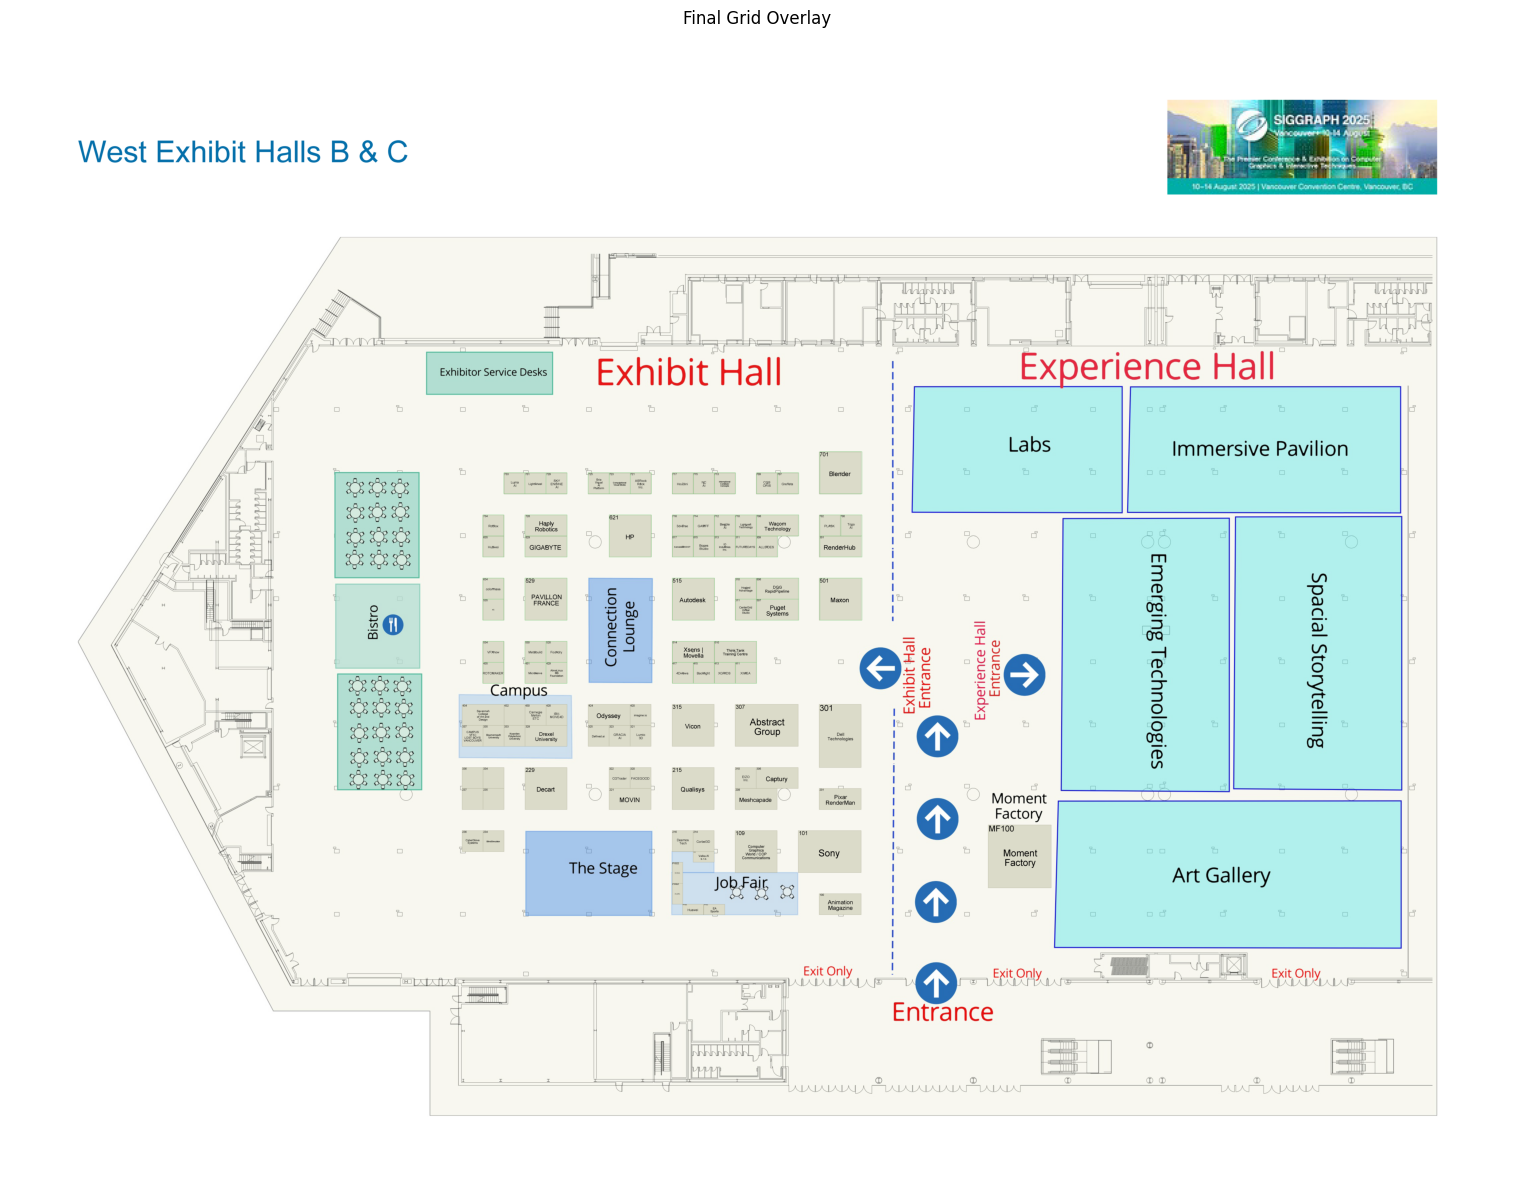

In [4]:
import cv2
import matplotlib.pyplot as plt
from core.grid import load_grid, overlay_grid

# 設定圖片路徑和 grid 檔案路徑
image_path = '../large_map.png'
grid_path = '../data/grid.json'

# 載入圖片和 grid
image = cv2.imread(image_path)
cells = load_grid(grid_path)

if image is not None and cells:
    print(f"成功載入 {len(cells)} 個格子，準備進行可視化...")
    # 將 grid 覆蓋到圖片上
    overlayed_image = overlay_grid(image, cells, show_idx=True)
    
    # 使用 matplotlib 在 notebook 中顯示圖片
    plt.figure(figsize=(20, 15))
    # BGR to RGB for correct color display in matplotlib
    plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
    plt.title('Final Grid Overlay')
    plt.axis('off')
    plt.show()
elif image is None:
    print(f"錯誤：無法載入圖片 {image_path}")
else:
    print(f"從 {grid_path} 未載入任何格子，沒有東西可以顯示。")

In [5]:
cv2.imwrite("large_map_gridviz.png", overlayed_image)

True